#  Classical-quantum Neural Network for binary classification

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, random, json, math
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import re

## Data loading

In [2]:
num_classes = 2
max_image_in_class = 300
train_part = 0.8
val_part = 0.5 # from 1 - train_part

# hyper parameters
train_flag = False
epochs=30
initial_lr = 0.0005
w_decay = 0.0001
q_reps = 3

In [3]:
dataset_path = 'Dataset/'
dataset_name = 'task-3-dataset.csv'
df = pd.read_csv(dataset_path+dataset_name)
text = list(df['отзывы'])

In [4]:
lemmatize = nltk.WordNetLemmatizer()
stop_words = set(stopwords.words('russian'))
new_text = []
for i in df['отзывы']:
    text_ = re.sub("[^a-zA-Zа-яА-Я1-9]"," ",i) 
    text_ = nltk.word_tokenize(text_, language='russian')
    text_ = [word for word in text_ if word not in stop_words]
    text_ = [lemmatize.lemmatize(word) for word in text_]
    text_ = " ".join(text_)
    new_text.append(text_)

In [5]:
count = CountVectorizer(stop_words="english")
matrix = count.fit_transform(new_text).toarray()
max_len = len(matrix[0])
print(max_len)

1160


In [6]:
d = {'text_vec': matrix.tolist(), 'val': [1 if x=='+' else 0 for x in df['разметка']]}
df2 = pd.DataFrame(data=d)

df_train = df2[:int(len(df2)*0.8)]
df_test = df2.drop(df_train.index)
df_val = df_test[:int(len(df_test)*0.5)]
df_test = df_test.drop(df_val.index)

## Classical methods

In [8]:
logreg = LogisticRegression()
result_logreg = logreg.fit(df_train['text_vec'].tolist(), df_train['val'].tolist())
logreg.score(df_test['text_vec'].tolist(),df_test['val'].tolist())

0.7142857142857143

In [40]:
nb = GaussianNB()
result_bayes = nb.fit(df_train['text_vec'].tolist(), df_train['val'].tolist())
nb.score(df_test['text_vec'].tolist(),df_test['val'].tolist())

0.8095238095238095

In [41]:
metodsvm = svm.SVC(kernel='sigmoid')
result_svm = metodsvm.fit(df_train['text_vec'].tolist(), df_train['val'].tolist())
metodsvm.score(df_test['text_vec'].tolist(),df_test['val'].tolist())

0.7619047619047619

## The Network

In [42]:
n_input_dim = max_len
n_hidden2 = 256
n_hidden3 = 64
num_q = num_classes
n_output =  1


class QNet(nn.Module):
    def __init__(self):
        super(QNet, self).__init__()
        self.layer_2 = nn.Linear(n_input_dim, n_hidden2)
        self.layer_3 = nn.Linear(n_hidden2, n_hidden3)
        self.layer_qin = nn.Linear(n_hidden3, num_q)
        self.layer_qout = nn.Linear(num_q, n_output)
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_2(inputs))
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.dropout(x)
        x = self.relu(self.layer_qin(x))
        x = self.sigmoid(self.layer_qout(x))
        
        return x
    

model = QNet()
print(model)

QNet(
  (layer_2): Linear(in_features=1160, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=64, bias=True)
  (layer_qin): Linear(in_features=64, out_features=2, bias=True)
  (layer_qout): Linear(in_features=2, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=w_decay, amsgrad=True)
loss_fn = nn.BCELoss()
def train_loop(dataloader, model, loss_fn, optimizer, history):
    size = len(dataloader)

    loss_, accuracy = 0, 0
    for row in dataloader.iterrows():
        pred = model(torch.tensor(row[1]['text_vec'], dtype=torch.float, requires_grad=True)).float()

        loss = loss_fn(pred, torch.tensor([row[1]['val']]).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_ += loss.item()
        accuracy += (round(pred[0].tolist()) == row[1]['val'])
    
    loss_ /= size
    accuracy /= size
    print(loss_, accuracy)
    history['train_loss'].append(loss_)
    history['train_accuracy'].append(accuracy)
    return loss_, accuracy


def val_loop(dataloader, model, loss_fn, history):
    size = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        for row in dataloader.iterrows():
            
            pred = model(torch.tensor(row[1]['text_vec'], dtype=torch.float, requires_grad=True)).float()
            
            loss += loss_fn(pred, torch.tensor([row[1]['val']]).float())
            accuracy += (round(pred[0].tolist()) == row[1]['val'])

    loss /= size
    accuracy /= size
    print(loss.item(), accuracy)
    history['val_loss'].append(loss.item())
    history['val_accuracy'].append(accuracy)
    return loss, accuracy

def test_loop(dataloader, model, loss_fn, history, num_classes):
    size = len(dataloader)
    count = []

    for i in range(num_classes):
        count.append(0)

    with torch.no_grad():
        for row in dataloader.iterrows():
            
            pred = model(torch.tensor(row[1]['text_vec'], dtype=torch.float, requires_grad=True)).float()
            count[row[1]['val']] += 1
            history['test_loss'][row[1]['val']][0] += (loss_fn(pred, torch.tensor([row[1]['val']]).float())).item()
            history['test_accuracy'][row[1]['val']][0] += round(pred[0].tolist()) == row[1]['val']

    loss, accuracy = 0, 0
    for i in range(num_classes):
        history['test_loss'][i][0] /= size
        loss += history['test_loss'][i][0]
        history['test_accuracy'][i][0] /= count[i]
        accuracy += history['test_accuracy'][i][0]

    loss /= num_classes
    accuracy /= num_classes
    
    return loss, accuracy

In [44]:
history = {
    'train_loss':[],
    'train_accuracy':[],
    'val_loss':[],
    'val_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}

for i in range(num_classes):
    history['test_loss'].append([0])
    history['test_accuracy'].append([0])


In [45]:
if(train_flag):
    for t in tqdm(range(epochs), bar_format="{elapsed} Elapsed | {percentage:3.0f}% done |{bar}| {n_fmt}/{total_fmt} [{remaining} remaining | {rate_fmt}{postfix}]", unit="epoch", total=epochs):
        train_loop(df_train, model, loss_fn, optimizer, history)
        val_loop(df_val, model, loss_fn, history)
    print("train loss and accuracy: ", history['train_loss'][-1], history['train_accuracy'][-1])
    print("val loss and accuracy: ", history['val_loss'][-1], history['val_accuracy'][-1])
else:
    model.load_state_dict(torch.load("param3_base.pth", weights_only=True))
    model.eval()

00:00 Elapsed |   3% done |▎         | 1/30 [00:21 remaining |  1.34epoch/s]

0.6938670850580647 0.5654761904761905
0.740489661693573 0.47619047619047616


00:01 Elapsed |   7% done |▋         | 2/30 [00:20 remaining |  1.35epoch/s]

0.6473692226711483 0.5654761904761905
0.7453681826591492 0.47619047619047616


00:02 Elapsed |  10% done |█         | 3/30 [00:20 remaining |  1.29epoch/s]

0.5137573415288769 0.5654761904761905
0.7817532420158386 0.47619047619047616


00:03 Elapsed |  13% done |█▎        | 4/30 [00:19 remaining |  1.31epoch/s]

0.45382740958863604 0.5654761904761905
0.7781233787536621 0.47619047619047616


00:03 Elapsed |  17% done |█▋        | 5/30 [00:19 remaining |  1.30epoch/s]

0.4261898763798283 0.5654761904761905
0.751693606376648 0.47619047619047616


00:04 Elapsed |  20% done |██        | 6/30 [00:18 remaining |  1.32epoch/s]

0.4035050680116524 0.5654761904761905
0.7527790665626526 0.47619047619047616


00:05 Elapsed |  23% done |██▎       | 7/30 [00:17 remaining |  1.33epoch/s]

0.3884526024469914 0.5654761904761905
0.7642874717712402 0.47619047619047616


00:06 Elapsed |  27% done |██▋       | 8/30 [00:16 remaining |  1.33epoch/s]

0.3738183506366618 0.5654761904761905
0.8077753782272339 0.47619047619047616


00:06 Elapsed |  30% done |███       | 9/30 [00:15 remaining |  1.34epoch/s]

0.3610237764928878 0.5654761904761905
0.8291020393371582 0.47619047619047616


00:07 Elapsed |  33% done |███▎      | 10/30 [00:14 remaining |  1.35epoch/s]

0.3495460196357544 0.5654761904761905
0.8362017869949341 0.47619047619047616


00:08 Elapsed |  37% done |███▋      | 11/30 [00:14 remaining |  1.35epoch/s]

0.3383220130277166 0.5654761904761905
0.8545864820480347 0.47619047619047616


00:08 Elapsed |  40% done |████      | 12/30 [00:13 remaining |  1.36epoch/s]

0.32730125283322675 0.5654761904761905
0.8853778839111328 0.47619047619047616


00:09 Elapsed |  43% done |████▎     | 13/30 [00:12 remaining |  1.36epoch/s]

0.31685575393574955 0.5654761904761905
0.8812716603279114 0.47619047619047616


00:10 Elapsed |  47% done |████▋     | 14/30 [00:11 remaining |  1.36epoch/s]

0.30797880973811764 0.8928571428571429
0.7063827514648438 0.7142857142857143


00:11 Elapsed |  50% done |█████     | 15/30 [00:11 remaining |  1.32epoch/s]

0.29779564766586447 0.9880952380952381
0.7658682465553284 0.7142857142857143


00:11 Elapsed |  53% done |█████▎    | 16/30 [00:10 remaining |  1.33epoch/s]

0.288359779944635 0.9880952380952381
0.7648955583572388 0.7619047619047619


00:12 Elapsed |  57% done |█████▋    | 17/30 [00:09 remaining |  1.34epoch/s]

0.2794675109039211 0.9880952380952381
0.7843899726867676 0.7142857142857143


00:13 Elapsed |  60% done |██████    | 18/30 [00:08 remaining |  1.35epoch/s]

0.27097404733750113 0.9880952380952381
0.8256591558456421 0.7619047619047619


00:14 Elapsed |  63% done |██████▎   | 19/30 [00:08 remaining |  1.32epoch/s]

0.26297827898371584 0.9880952380952381
0.8211022615432739 0.7619047619047619


00:15 Elapsed |  67% done |██████▋   | 20/30 [00:07 remaining |  1.32epoch/s]

0.25548477374484596 0.9880952380952381
0.815769374370575 0.7142857142857143


00:15 Elapsed |  70% done |███████   | 21/30 [00:06 remaining |  1.33epoch/s]

0.2479866291737822 0.9880952380952381
0.7737165093421936 0.7142857142857143


00:16 Elapsed |  73% done |███████▎  | 22/30 [00:06 remaining |  1.33epoch/s]

0.24104642880834865 0.9880952380952381
0.8346895575523376 0.7142857142857143


00:17 Elapsed |  77% done |███████▋  | 23/30 [00:05 remaining |  1.32epoch/s]

0.23488580358829084 0.9880952380952381
0.7131584286689758 0.6666666666666666


00:18 Elapsed |  80% done |████████  | 24/30 [00:04 remaining |  1.32epoch/s]

0.22819409572918076 0.9880952380952381
0.784583330154419 0.7142857142857143


00:18 Elapsed |  83% done |████████▎ | 25/30 [00:03 remaining |  1.31epoch/s]

0.2219947309887743 0.9880952380952381
0.7760754823684692 0.7142857142857143


00:19 Elapsed |  87% done |████████▋ | 26/30 [00:03 remaining |  1.30epoch/s]

0.2161911104186348 0.9880952380952381
0.7611220479011536 0.7142857142857143


00:20 Elapsed |  90% done |█████████ | 27/30 [00:02 remaining |  1.25epoch/s]

0.21085930908296072 0.9880952380952381
0.6409382224082947 0.7619047619047619


00:21 Elapsed |  93% done |█████████▎| 28/30 [00:01 remaining |  1.25epoch/s]

0.20554382659878592 0.9880952380952381
0.6610367298126221 0.7619047619047619


00:22 Elapsed |  97% done |█████████▋| 29/30 [00:00 remaining |  1.23epoch/s]

0.20049555267759556 0.9880952380952381
0.5952075719833374 0.7619047619047619


00:22 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  1.31epoch/s]

0.1957461519929728 0.9880952380952381
0.5051848292350769 0.7142857142857143
train loss and accuracy:  0.1957461519929728 0.9880952380952381
val loss and accuracy:  0.5051848292350769 0.7142857142857143


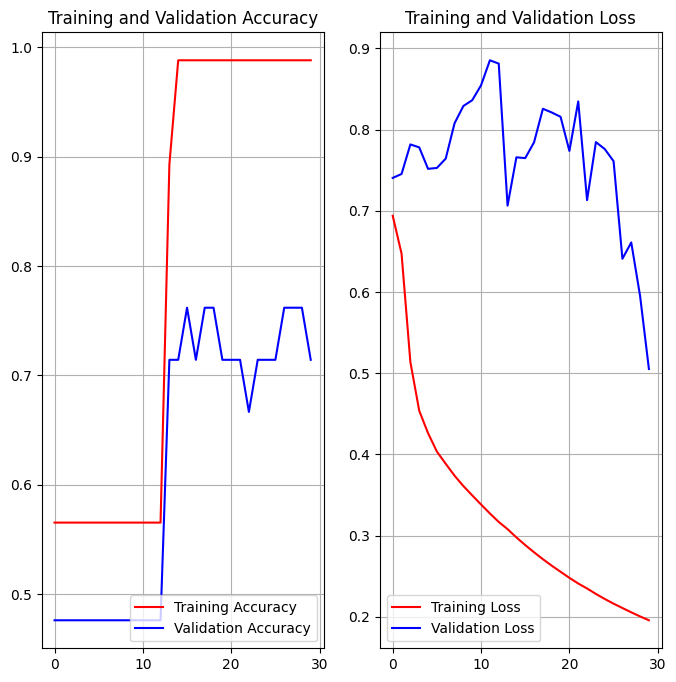

In [46]:
if(train_flag):
    epochs_range = range(epochs)
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy', color='red')
    plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy', color='blue')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='red')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss', color='blue')
    plt.legend(loc='lower left')
    plt.title('Training and Validation Loss')
    plt.grid()
    plt.show()


In [47]:
tloss, tacc = test_loop(df_test, model, loss_fn, history, 2)
print("test loss and accuracy: ", tloss, tacc)
for i in range (num_classes):
    print("test loss and accuracy on target ", i, ": ", history['test_loss'][i][0], history['test_accuracy'][i][0])

test loss and accuracy:  0.18778929702131109 0.675
test loss and accuracy on target  0 :  0.12905479754720414 0.6
test loss and accuracy on target  1 :  0.24652379649541803 0.75
